In [2]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textstat as ts

import nltk
import spacy
from gensim import corpora
from gensim.models import LdaModel, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from nltk import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tqdm import tqdm

from wordcloud import WordCloud

import matplotlib.colors as mcolors

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)
red = (168/255, 96/255, 93/255)
pale_yellow = (164/255, 168/255, 93/255)

color_palette = sns.color_palette([grey, darkgreen, teal, blue, yellow, red, pale_yellow])

# Feedback Analysis

In [4]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df['grade'] = pd.Categorical(feedback_df['grade'],
                                   ['A++', 'A+', 'A', 'A-',
                                    'B+', 'B', 'B-',
                                    'C+', 'C', 'C-',
                                    'D+', 'D', 'D-',
                                    'F'])
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Proporition of Feedback with comments

In [5]:
count_df = feedback_df.groupby(['skill', 'grade']).count()
count_df['prop_present'] = (count_df['comments'] / count_df['assignment_number']) * 100
count_df['prop_missing'] = 100 - count_df['prop_present']
count_df.head()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7074/2623102532.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = feedback_df.groupby(['skill', 'grade']).count()


assignment_number  comments  participant_id  batch  \
skill         grade                                                       
Code Elegance A++                  148        78             148    148   
              A+                   199       114             199    199   
              A                    191       138             191    191   
              A-                   132        85             132    132   
              B+                   117        71             117    117   

                     prop_present  prop_missing  
skill         grade                              
Code Elegance A++       52.702703     47.297297  
              A+        57.286432     42.713568  
              A         72.251309     27.748691  
              A-        64.393939     35.606061  
              B+        60.683761     39.316239

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7074/946435587.py:1: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  g = sns.barplot(count_df, x='grade', y='prop_present', hue='skill', palette=color_palette)


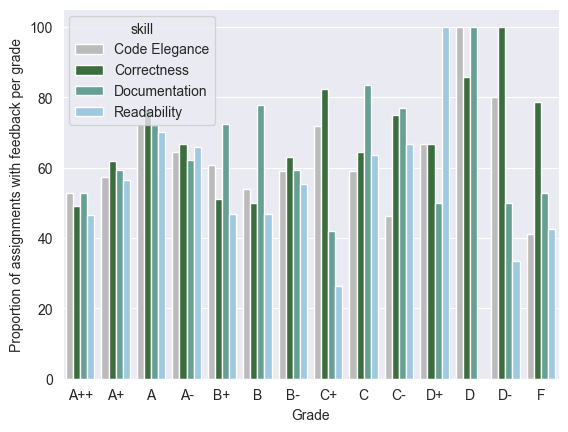

In [6]:
g = sns.barplot(count_df, x='grade', y='prop_present', hue='skill', palette=color_palette)
g.set_ylabel('Proportion of assignments with feedback per grade')
g.set_xlabel('Grade')
g.get_figure().savefig('plots/grades_prop_present.pdf', bbox_inches='tight')

### Length

In [7]:
length_df = feedback_df[~feedback_df['comments'].isna()].copy()
length_df['length'] = length_df['comments'].apply(lambda comment: len(simple_preprocess(comment)))
length_df.head()

,assignment_number,comments,skill,participant_id,batch,grade,length
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,22
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,36
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,36
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,21
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,21


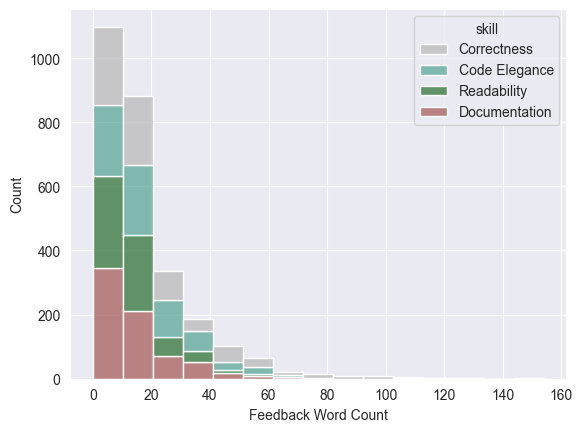

In [8]:
g = sns.histplot(length_df, x='length', binwidth=10, hue='skill', palette=sns.color_palette([grey, teal, darkgreen, red]), multiple='stack', hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])
g.set_xlabel('Feedback Word Count')
g.get_figure().savefig('plots/length_hist.pdf', bbox_inches='tight')

### Length to grade

<Axes: xlabel='grade_code', ylabel='length'>

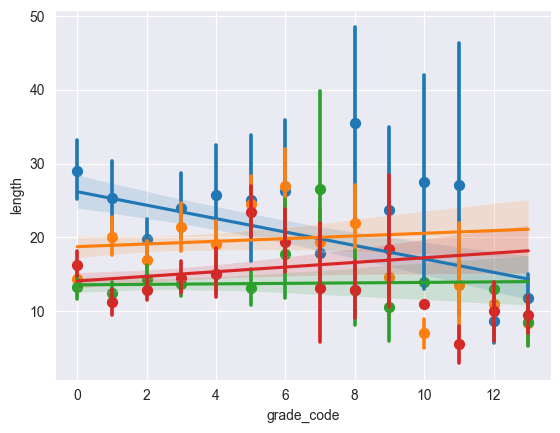

In [18]:
length_df['grade_code'] = length_df['grade'].cat.codes
# sns.barplot(length_df, x='grade', y='length', hue='skill', alpha=0.5, palette=color_palette, errorbar=None)
g = sns.regplot(length_df[length_df['skill'] == 'Correctness'], x='grade_code', y='length', x_estimator=np.mean) # Blue
sns.regplot(length_df[length_df['skill'] == 'Code Elegance'], x='grade_code', y='length', x_estimator=np.mean) # Orange
sns.regplot(length_df[length_df['skill'] == 'Readability'], x='grade_code', y='length', x_estimator=np.mean) # Green
sns.regplot(length_df[length_df['skill'] == 'Documentation'], x='grade_code', y='length', x_estimator=np.mean) # Red

### Readability Metrics

In [9]:
metric_df = length_df.copy()
metric_df = metric_df[~metric_df['comments'].isna()]

metric_df['flesch_kincaid_grade'] = metric_df['comments'].apply(lambda comment: ts.flesch_kincaid_grade(str(comment)))
metric_df['gunning_fog'] = metric_df['comments'].apply(lambda comment: ts.gunning_fog(str(comment)))

metric_df.head()

,assignment_number,comments,skill,participant_id,batch,grade,length,grade_code,flesch_kincaid_grade,gunning_fog
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,22,4,12.3,17.90
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,36,1,10.9,12.69
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,36,3,11.4,13.82
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,21,3,6.0,10.42
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,21,3,6.0,10.42


[Text(0.5, 0, 'Flesch-Kincaid Grade Level')]

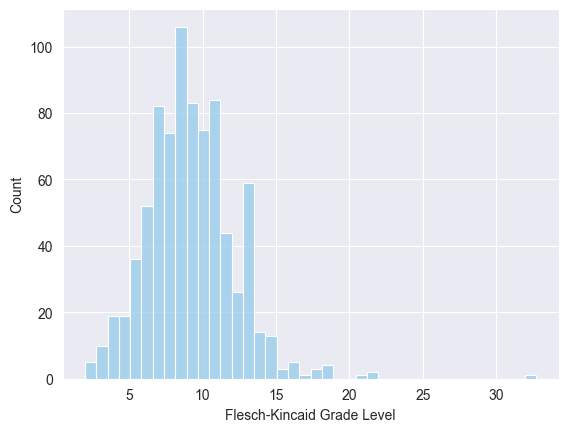

In [10]:
g = sns.histplot(metric_df[metric_df['length'] >= 20], x='flesch_kincaid_grade', color=blue)
g.set(xlabel='Flesch-Kincaid Grade Level')

[Text(0.5, 0, 'Gunning Fog Index')]

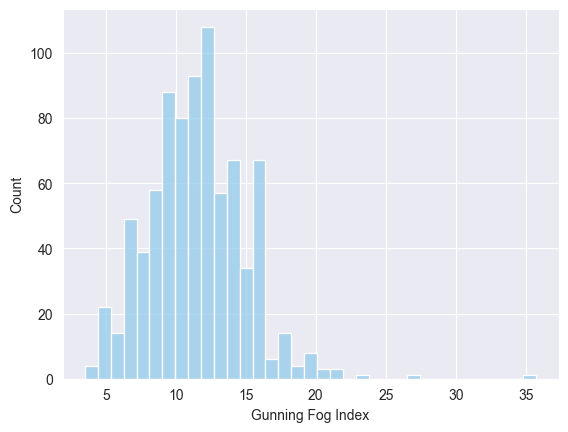

In [11]:
g = sns.histplot(metric_df[metric_df['length'] >= 20], x='gunning_fog', color=blue)
g.set(xlabel='Gunning Fog Index')

## NLP Techniques

In [12]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [13]:
base_stopwords = nltk.corpus.stopwords.words('english')
base_stopwords += ['correctness', 'code elegance', 'readability', 'documentation']

### Sentiment

In [14]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,True


In [15]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


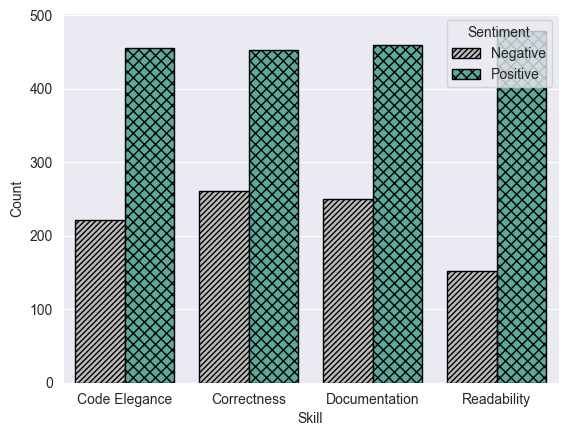

In [16]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('../plots/sentiment.pdf', bbox_inches='tight')

### LDA Topic Analysis
https://link.springer.com/article/10.1007/s44217-023-00051-0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9260886/

Code adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#4.-Build-the-Bigram,-Trigram-Models-and-Lemmatize

In [17]:
def process_words(texts, bigram_mod, trigram_mod, stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stem=False):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    if stem:
        stemmer = SnowballStemmer('english')
        texts_out = [[stemmer.stem(word) for word in doc] for doc in texts_out]
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]

    return texts_out

In [18]:
def get_data(skill, addition_stopwords):
    
    stopwords = base_stopwords + addition_stopwords
    
    skill_df = nlp_df[nlp_df['skill'] == skill][['assignment_number', 'comments', 'participant_id', 'batch']].reset_index(drop=True)
    bigram = Phrases(skill_df['comments'], min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = Phrases(bigram[skill_df['comments']], threshold=100)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    processed_text = process_words(skill_df['comments'], bigram_mod, trigram_mod, stopwords, stem=False, allowed_postags=['NOUN', 'ADJ', 'VERB'])
    dictionary = corpora.Dictionary(processed_text)
    dictionary.filter_extremes(no_below=15, no_above=0.3, keep_n=10000)
    corpus = [dictionary.doc2bow(text) for text in processed_text]

    model = TfidfModel(corpus)
    tfidf_corpus = [model[i] for i in corpus]
    
    skill_df['processed_text'] = processed_text
    
    return tfidf_corpus, dictionary, skill_df
    

In [19]:
def generate_topic_model(corpus, dictionary, processed_text, num_topics=5):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=10, passes=15)
    cm = CoherenceModel(model=lda_model, texts=processed_text, coherence='u_mass')
    coherence = cm.get_coherence()
    return lda_model, coherence


In [20]:
def generate_topic_models(tfidf_corpus, dictionary, processed_text):
    models = {}
    coherence_results = []
    
    for topic_count in tqdm(range(2, 10)):
        model, coherence = generate_topic_model(tfidf_corpus, dictionary, processed_text, topic_count)
        models[topic_count] = model
        coherence_results.append({'topic_count':topic_count, 'coherence': coherence})
        
    return models, pd.DataFrame(coherence_results)
    

In [21]:
def run_lda(skill, addition_stopwords=None):
    if addition_stopwords is None:
        addition_stopwords = []
    
    tfidf_corpus, dictionary, skill_df = get_data(skill, addition_stopwords)
    models, coherence_df= generate_topic_models(tfidf_corpus, dictionary, skill_df['processed_text'])
    print(coherence_df[coherence_df['coherence'] == coherence_df['coherence'].max()])

    g = sns.lineplot(coherence_df, x='topic_count', y='coherence')
    g.set(title=skill)
    return models, tfidf_corpus, skill_df

#### Plots

In [22]:
def run_pyLDAvis(models, topic_count, corpus):
    return pyLDAvis.gensim.prepare(models[topic_count], corpus, dictionary=models[topic_count].id2word)

In [23]:
def generate_word_cloud(skill, models, topic_count, topic_names=None, additional_stopwords=None):
    if additional_stopwords is None:
        additional_stopwords = {}
        
    stopwords = base_stopwords + additional_stopwords
        
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None
        
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=15,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    
    topics = models[topic_count].show_topics(formatted=False, num_words=5)
    
    row_count = topic_count // 2 + topic_count % 2
    fig, axes = plt.subplots(row_count, 2, figsize=(10,10), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i >= topic_count:
            break
            
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        if topic_names is None:
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        else:
            plt.gca().set_title('Topic: ' + topic_names[i], fontdict=dict(size=16))
        plt.gca().axis('off')

    if topic_count % 2 == 1:
        fig.delaxes(axes[row_count - 1, 1])
    
    fig.suptitle(skill, fontsize=22, y=1.05)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [24]:
def get_mosaic(topic_count):
    if topic_count == 2:
        return """AABB"""
    elif topic_count == 3:
        return  """AABB
                    .CC."""
    elif topic_count == 4:
        return """AABB
                  CCDD"""
    else:
        return '\n'.join("ABCDEFGHIJ"[:topic_count])

In [25]:
def generate_word_count_mosaic(topic_count, max_word_count, max_importance, topic_names, skill, df):
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplot_mosaic(get_mosaic(topic_count), figsize=(16, 10), dpi=160)

    colors = [teal, darkgreen, yellow, blue]

    for i, ax in enumerate(axes):
        if i >= topic_count:
            break
        axes[ax].barh(y='word', width="word_count", data=df.loc[df.topic_id==i, :], color=colors[i],height=0.5, alpha=0.3, label='Word Count')
        ax_twin = axes[ax].twiny()
        ax_twin.barh(y='word', width="importance", data=df.loc[df.topic_id==i, :], color=colors[i], height=0.2, label='Weights', hatch='/')
        axes[ax].set_xlabel('Word Count')
        axes[ax].set_xlim(0, max_word_count)
        ax_twin.set_xlim(0, max_importance)

        if topic_names is None:
            axes[ax].set_title('Topic: ' + str(i), fontsize=16)
        else:
            axes[ax].set_title('Topic: ' + topic_names[i], fontsize=16)
        axes[ax].tick_params(axis='x', left=False)

        ax_twin.legend(loc='upper right', handles=[mpatches.Patch(color=colors[i], alpha=0.3, label='Word Count'), mpatches.Patch(color=colors[i], hatch='/', label='Weights')])

    fig.tight_layout(w_pad=2)
    fig.suptitle(skill + ' - Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
    fig.savefig(f'plots/topic_word_count_{skill}.pdf', bbox_inches='tight')
    plt.show()

In [26]:
def generate_word_count_subplots(topic_count, max_word_count, max_importance, topic_names, skill, df):
    # Plot Word Count and Weights of Topic Keywords
    row_count = topic_count // 2 + topic_count % 2
    fig, axes = plt.subplots(row_count, 2, figsize=(16,10), sharey=True, dpi=160)

    colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=colors[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=colors[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=colors[i])
        ax_twin.set_ylim(0, max_importance)
        ax.set_ylim(0, max_word_count)
        ax.set_title('Topic: ' + str(i), color=colors[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(skill + ' - Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
    fig.savefig(f'plots/topic_word_count_{skill}.pdf', bbox_inches='tight')
    plt.show()

In [27]:
# Look for words in multiple topics and have higher frequency then weight. Add these to stop words
def generate_word_count(skill, models, topic_count, skill_df, topic_names=None, filter=False):
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None


    topics = models[topic_count].show_topics(formatted=False)
    data_flat = [w for w_list in skill_df['processed_text'] for w in w_list]
    counter = Counter(data_flat)
    
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])
    
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
    
    if filter:
        df = df[df['importance'] > 0.05].sort_values(by='importance', ascending=True)
    
    
    max_word_count = df['word_count'].max() + df['word_count'].max() * 0.1
    max_imporantance = df['importance'].max() + df['importance'].max() * 0.1
    
    if topic_count <= 4:
        generate_word_count_mosaic(topic_count, max_word_count, max_imporantance, topic_names, skill, df)
    else:
        generate_word_count_subplots(topic_count, max_word_count, max_imporantance, topic_names, skill, df)
    
    
    

### Generate DataFrame of Dominant Topic

In [28]:
def generate_dominant_topics_df(model, corpus, skill_df, topic_count, topic_names):
    if topic_names is None:
        topic_names = {i:i for i in range(topic_count)}
    
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'All_Topics'])
    
    for row_list in model[corpus]:
        row = row_list[0] if model.per_word_topics else row_list
        
        row = sorted(row, key=lambda x : (x[1]), reverse=True)
        
        # Dominant topic is first topic in list, and the first element in the tuple
        dominant_topic_number = row[0][0]
        dominant_topic_proportion = row[0][1]
        dominant_topic_keywords = ', '.join([word for word, prop in model.show_topic(dominant_topic_number)])
        
        all_topics = [(topic_names[topic[0]], topic[1]) for topic in row]

        temp_df = pd.DataFrame([{'Dominant_Topic': topic_names[dominant_topic_number], 'Perc_Contribution': dominant_topic_proportion, 'Topic_Keywords': dominant_topic_keywords, 'All_Topics': all_topics}])
        sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)
    
    return pd.concat([skill_df, sent_topics_df], axis=1)
            

In [29]:
def plot_dominant_topic(skill, skill_df):
    g = sns.countplot(skill_df, y='Dominant_Topic', order = skill_df['Dominant_Topic'].value_counts().index)
    g.set(title = skill, xlabel='Dominant Topic', ylabel='Count')
    g.get_figure().savefig(f'plots/count_dominant_{skill}.pdf', bbox_inches='tight')

### Correctness

100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

   topic_count  coherence
1            3 -14.023333


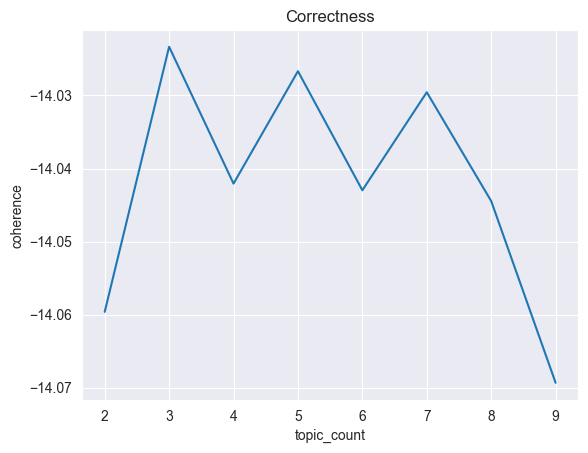

In [30]:
correctness_additional_stopwords = ['appear', 'effect', 'high', 'addition', 'animal', 'implement', 'base', 'core', 'simulation', 'plant', 'basic', 'weather', 'disease', 'work', 'specie', 'time', 'requirement', 'application', 'least', 'day', 'add', 'extension', 'attempt', 'class', 'predator', 'student', 'night', 'male', 'female', 'meet', 'include', 'technical', 'code', 'different', 'issue', 'comprehensive', 'assignment', 'run', 'finish', 'demonstrate', 'food', 'rabbit', 'prey', 'describe', 'list', 'indicate', 'approach', 'aptitude', 'track', 'baseline', 'behavior', 'behaviour', 'compete', 'gender', 'use', 'grass', 'source', 'extend', 'exceptional', 'distinguish', 'act', 'create', 'demonstrating', 'implementation', 'eat', 'breed', 'propagate', 'spread', 'seem', 'keep', 'resource', 'level', 'fight', 'growth', 'step', 'need', 'extra', 'feature', 'give', 'require', 'share', 'submission', 'function']
correctness_models, correctness_corpus, correctness_df= run_lda('Correctness', correctness_additional_stopwords)

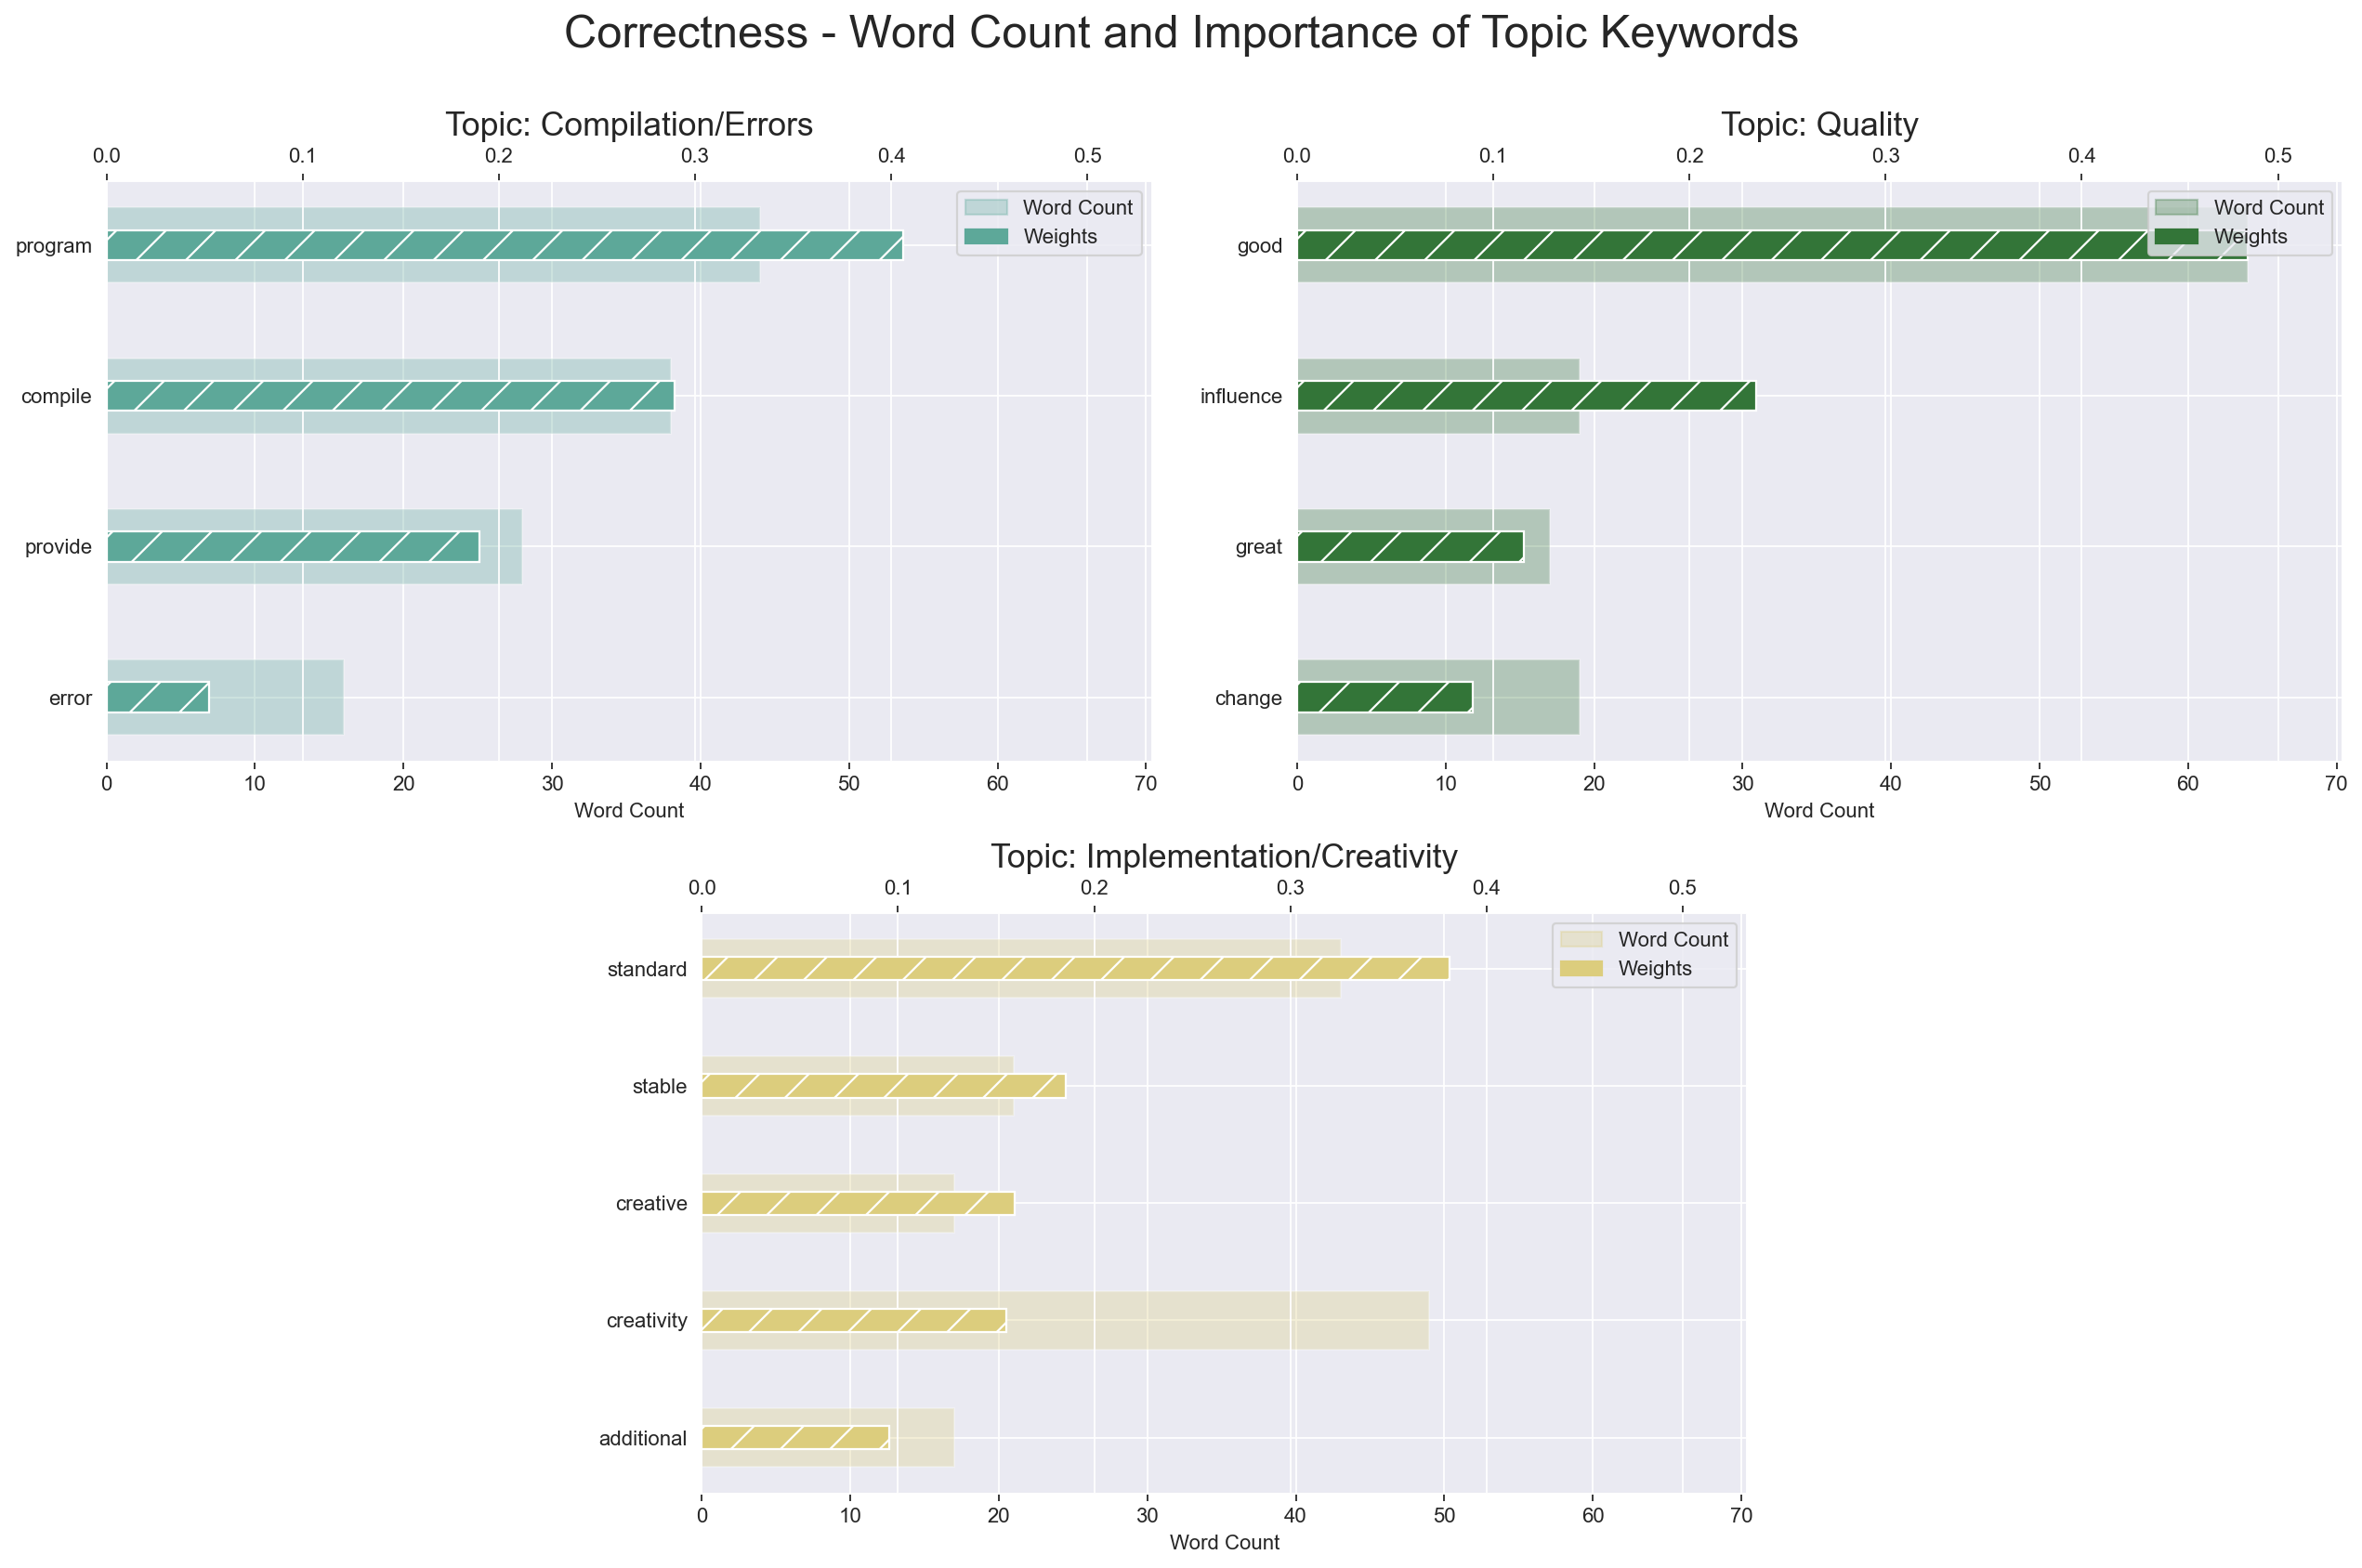

In [31]:
CORRECTNESS_TOPIC_COUNT = 3
correctness_topic_names = {0: 'Compilation/Errors',  1: 'Quality', 2: 'Implementation/Creativity'}
# generate_word_cloud('Correctness', correctness_models, CORRECTNESS_TOPIC_COUNT, additional_stopwords=correctness_additional_stopwords, topic_names=correctness_topic_names)
generate_word_count('Correctness', correctness_models, CORRECTNESS_TOPIC_COUNT, correctness_df, topic_names=correctness_topic_names, filter=True)
# run_pyLDAvis(correctness_models, CORRECTNESS_TOPIC_COUNT)

In [32]:
correctness_dominant_df = generate_dominant_topics_df(correctness_models[CORRECTNESS_TOPIC_COUNT], correctness_corpus, correctness_df, CORRECTNESS_TOPIC_COUNT, correctness_topic_names)
correctness_dominant_df.to_csv('../data/dominant_topics_correctness.csv', index=False)
correctness_dominant_df.head()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_95683/2469731638.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)


,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics
0,18.0,The core requirements like having 5+ species w...,15,1,"[species, challenge, mission, complete]",Compilation/Errors,0.333333,"program, compile, provide, error, correct, sta...","[(Compilation/Errors, 0.33333334), (Quality, 0..."
1,620.0,Excellent work on completing all core and chal...,15,1,"[excellent, complete, challenge, task, acting,...",Compilation/Errors,0.666572,"program, compile, provide, error, correct, sta...","[(Compilation/Errors, 0.6665721), (Quality, 0...."
2,466.0,The core requirements like having 5+ species w...,15,1,"[species, challenge, mission, complete]",Compilation/Errors,0.333333,"program, compile, provide, error, correct, sta...","[(Compilation/Errors, 0.33333334), (Quality, 0..."
3,591.0,The core requirements appear to be mostly impl...,15,1,"[squirrel, chicken, frog, hawk, non, squirrel,...",Compilation/Errors,0.333333,"program, compile, provide, error, correct, sta...","[(Compilation/Errors, 0.33333334), (Quality, 0..."
4,587.0,Excellent work on completing all core and chal...,15,1,"[excellent, complete, challenge, task, kind, c...",Compilation/Errors,0.333333,"program, compile, provide, error, correct, sta...","[(Compilation/Errors, 0.33333334), (Quality, 0..."


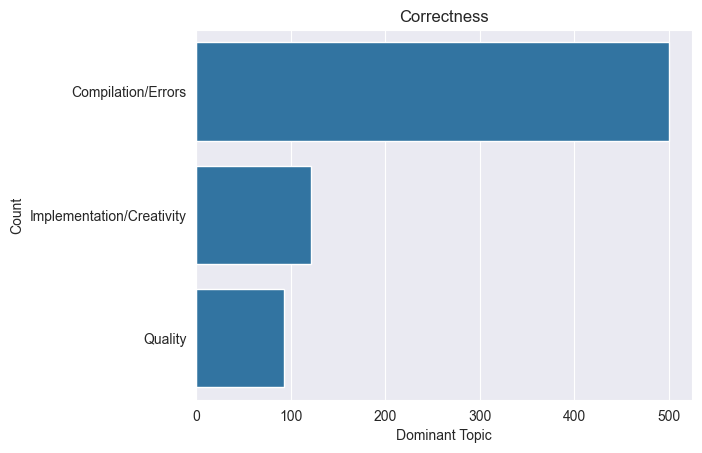

In [33]:
plot_dominant_topic('Correctness', correctness_dominant_df)

### Code Elegance

  0%|          | 0/8 [00:00<?, ?it/s]/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

   topic_count  coherence
5            7 -12.290135


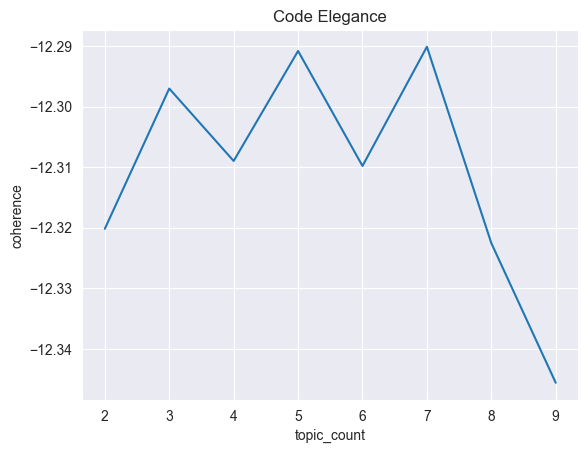

In [34]:
ce_additional_stopwords = ['animal', 'good', 'core', 'challenge', 'predator', 'make', 'plant', 'method', 'prey', 'weather', 'time', 'many', 'reuse', 'go', 'take', 'disease', 'object', 'functionality', 'principle', 'common', 'demonstrate', 'excellent', 'behavior', 'behaviour', 'task', 'type', 'orient', 'specie', 'share', 'need', 'little', 'provide', 'define', 'efficient', 'well', 'show', 'clean', 'specific', 'move', 'way', 'concept', 'utilise', 'feature', 'base', 'student', 'contain', 'example', 'implement', 'reduce', 'act', 'create', 'characteristic', 'allow', 'appropriate', 'lot', 'write', 'rewrite', 'improve', 'better', 'easy', 'effective', 'extend', 'repeat', 'logic', 'interface', 'variable', 'function', 'break', 'inheritance', 'abstraction', 'superclass', 'reusable']
code_elegance_models, code_elegance_corpus, code_elegance_df = run_lda('Code Elegance', ce_additional_stopwords)

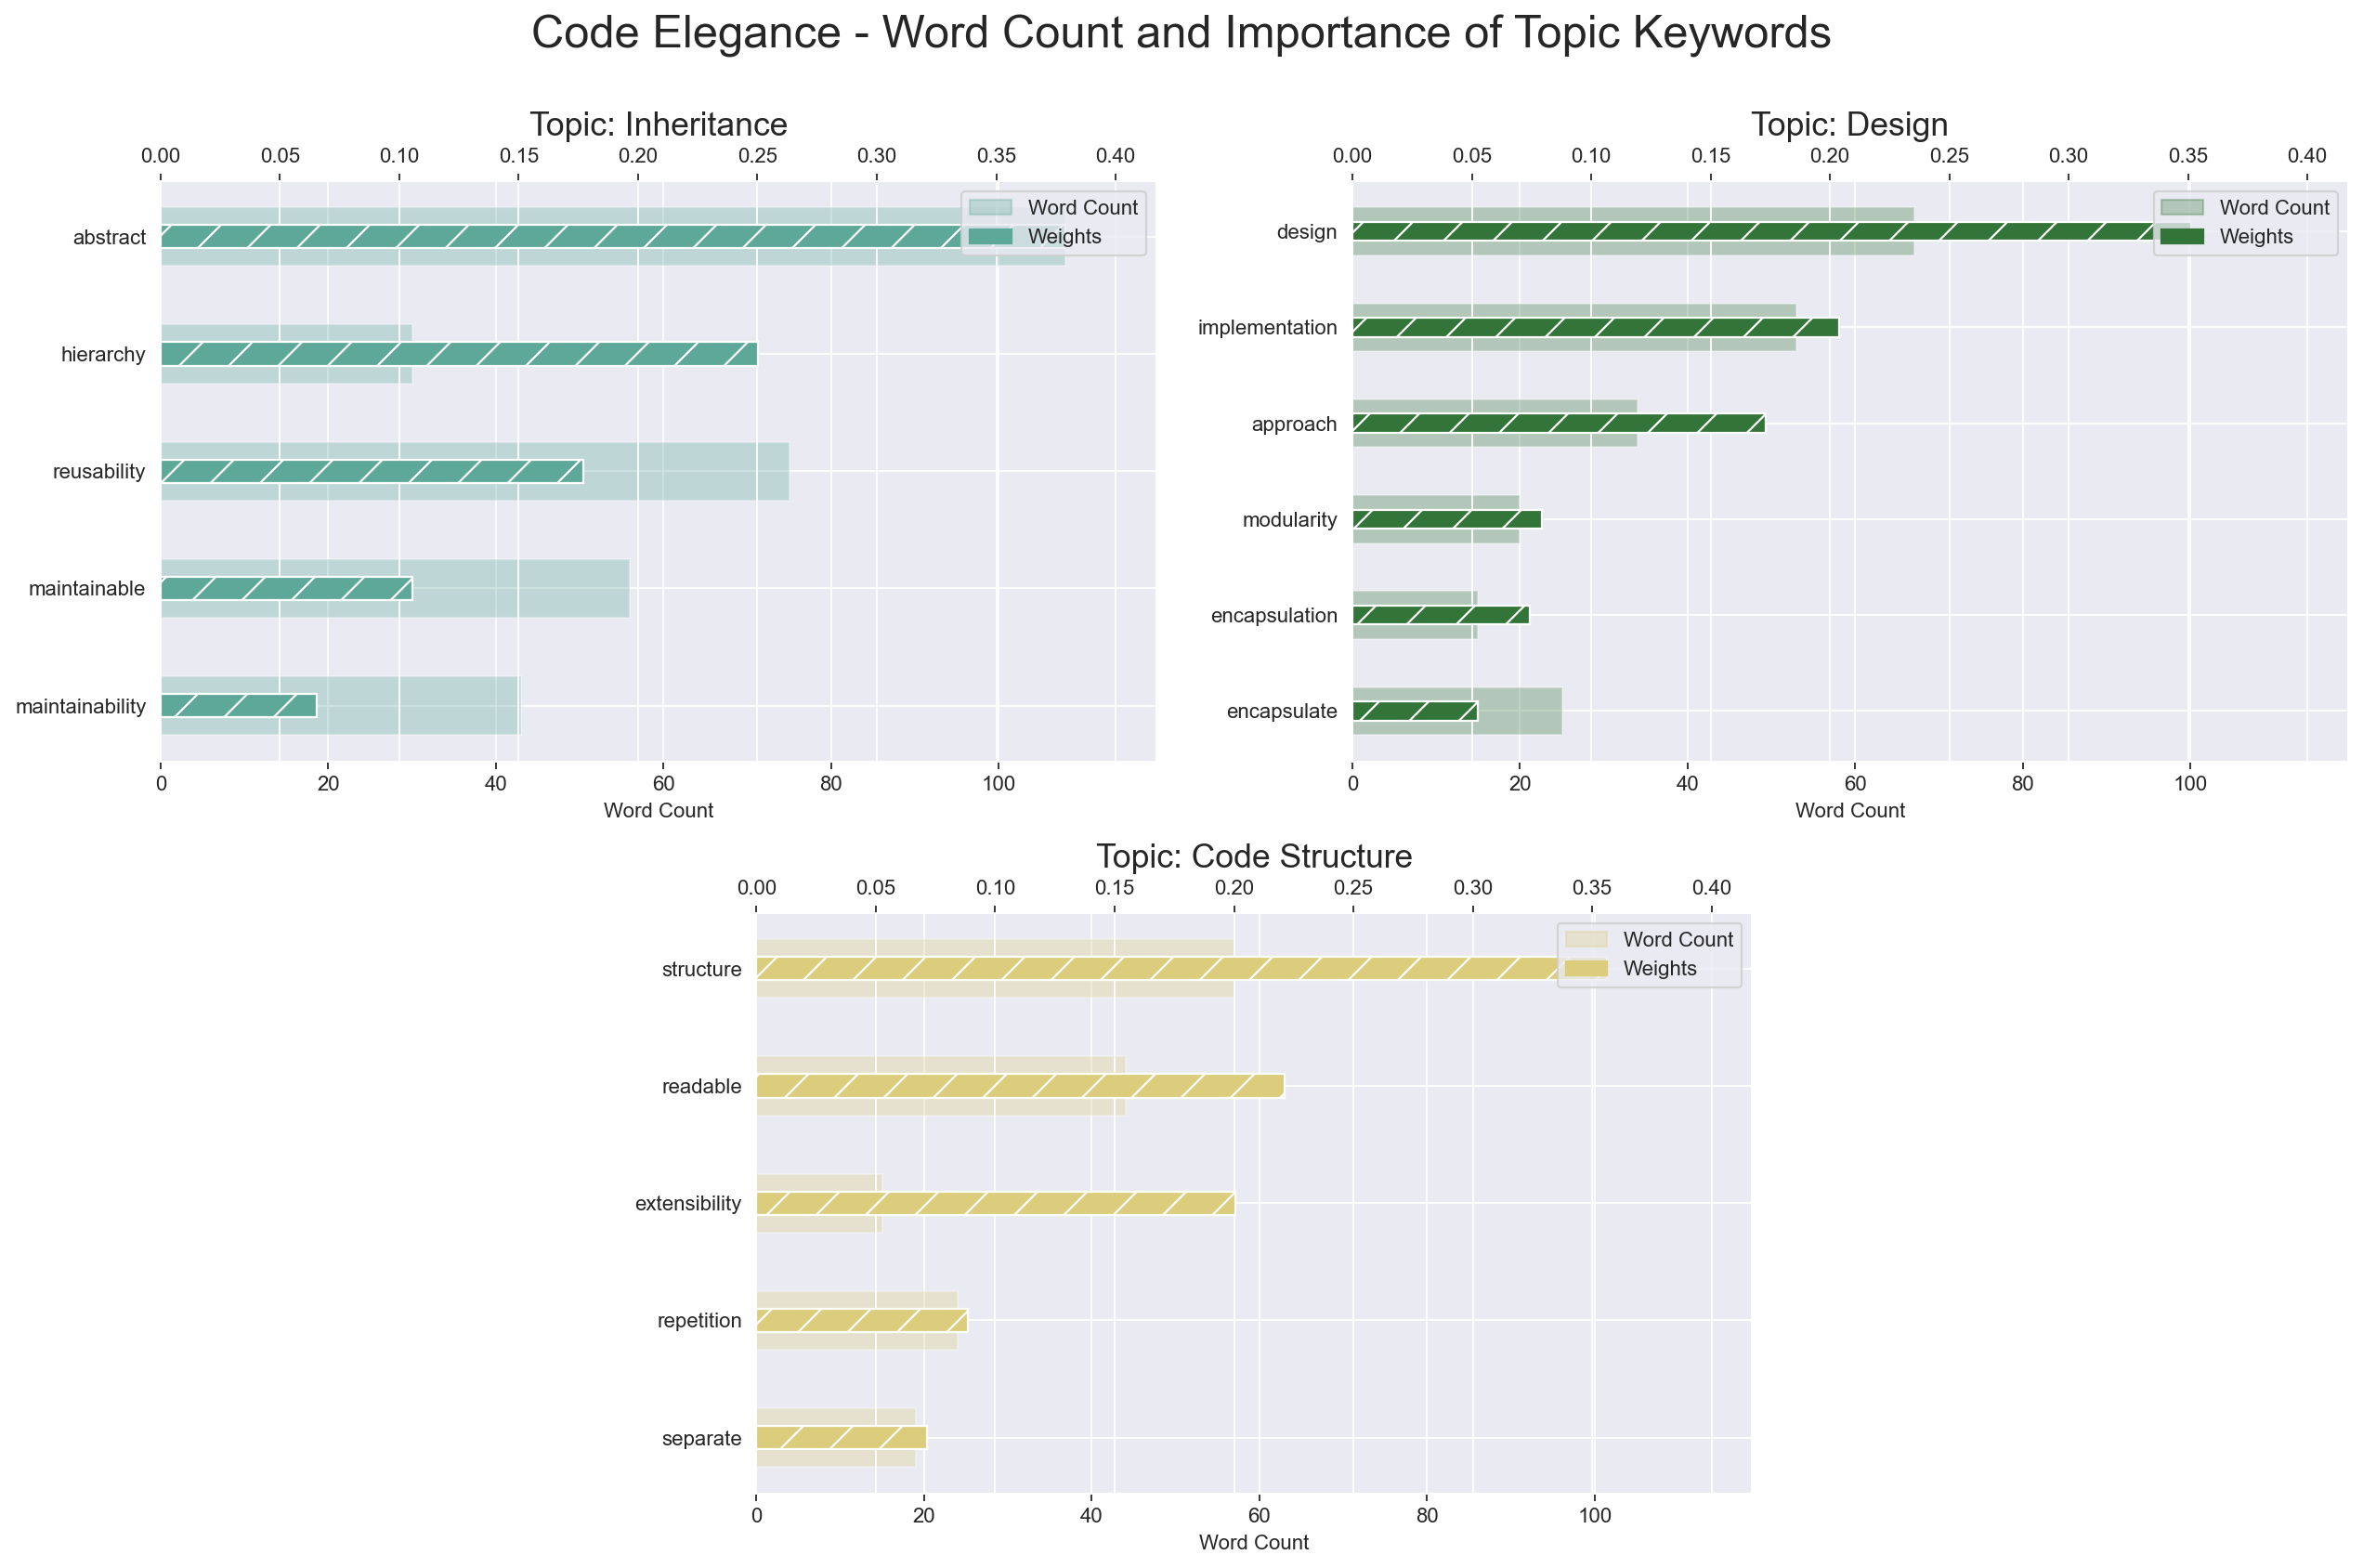

In [35]:
CE_TOPIC_COUNT = 3
ce_topic_names = {0: 'Inheritance', 1: 'Design', 2: 'Code Structure'}
# generate_word_cloud('Code Elegance', code_elegance_models, CE_TOPIC_COUNT, additional_stopwords=ce_additional_stopwords, topic_names=ce_topic_names)
generate_word_count('Code Elegance', code_elegance_models, CE_TOPIC_COUNT, code_elegance_df, topic_names=ce_topic_names, filter=True)
# run_pyLDAvis(code_elegance_models, CE_TOPIC_COUNT)

In [36]:
code_elegance_dominant_df = generate_dominant_topics_df(code_elegance_models[CE_TOPIC_COUNT], code_elegance_corpus, code_elegance_df,CE_TOPIC_COUNT, ce_topic_names)
code_elegance_dominant_df.to_csv('../data/dominant_topics_code_elegance.csv', index=False)
code_elegance_dominant_df.head()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_95683/2469731638.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)


,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics
0,18.0,The code is broken out into many separate clas...,15,1,"[separate, class, component, enable, decent, m...",Design,0.515050,"design, implementation, approach, modularity, ...","[(Design, 0.5150495), (Code Structure, 0.36153..."
1,620.0,The code makes excellent use of inheritance wi...,15,1,"[code, use, class, constant, parent, class, cl...",Code Structure,0.444894,"structure, readable, extensibility, repetition...","[(Code Structure, 0.4448938), (Inheritance, 0...."
2,466.0,The code is broken out into many separate clas...,15,1,"[separate, class, component, enable, decent, m...",Design,0.515049,"design, implementation, approach, modularity, ...","[(Design, 0.51504946), (Code Structure, 0.3615..."
3,591.0,The code follows good object-oriented design p...,15,1,"[follow, design, pattern, logical, separation,...",Design,0.721062,"design, implementation, approach, modularity, ...","[(Design, 0.7210623), (Code Structure, 0.13952..."
4,587.0,The code follows good object-oriented design p...,15,1,"[follow, design, pattern, logical, separation,...",Design,0.721062,"design, implementation, approach, modularity, ...","[(Design, 0.7210623), (Code Structure, 0.13952..."


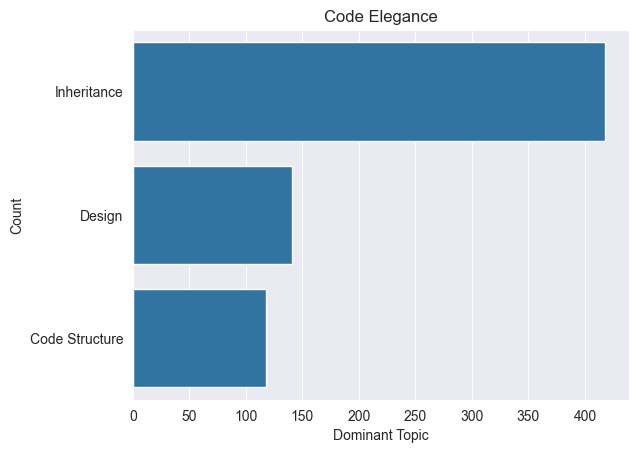

In [37]:
plot_dominant_topic('Code Elegance', code_elegance_dominant_df)

### Readability

100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


   topic_count  coherence
0            2  -8.649062


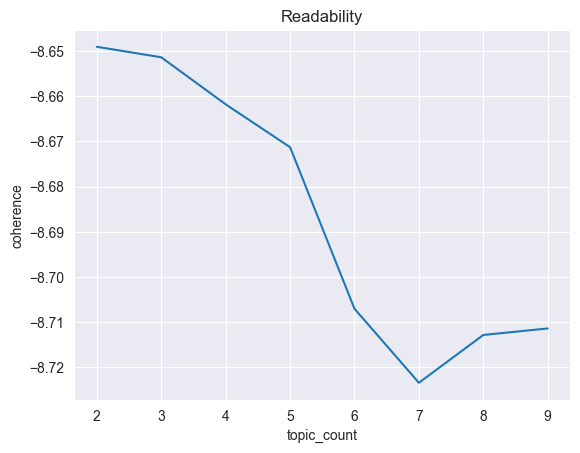

In [38]:
readability_additional_stopwords = ['format', 'appropriate',  'perfect', 'application', 'clean', 'codebase', 'overall', 'block', 'self', 'method', 'issue', 'protect', 'operation', 'perform', 'present', 'general', 'logical', 'single', 'access', 'miss', 'student', 'organize', 'contain', 'level', 'high', 'easy', 'great', 'make', 'class', 'private', 'public', 'organisation', 'identifi', 'function', 'variable', 'follow', 'meaningful', 'read']
readability_models, readability_corpus, readability_df = run_lda('Readability', readability_additional_stopwords)

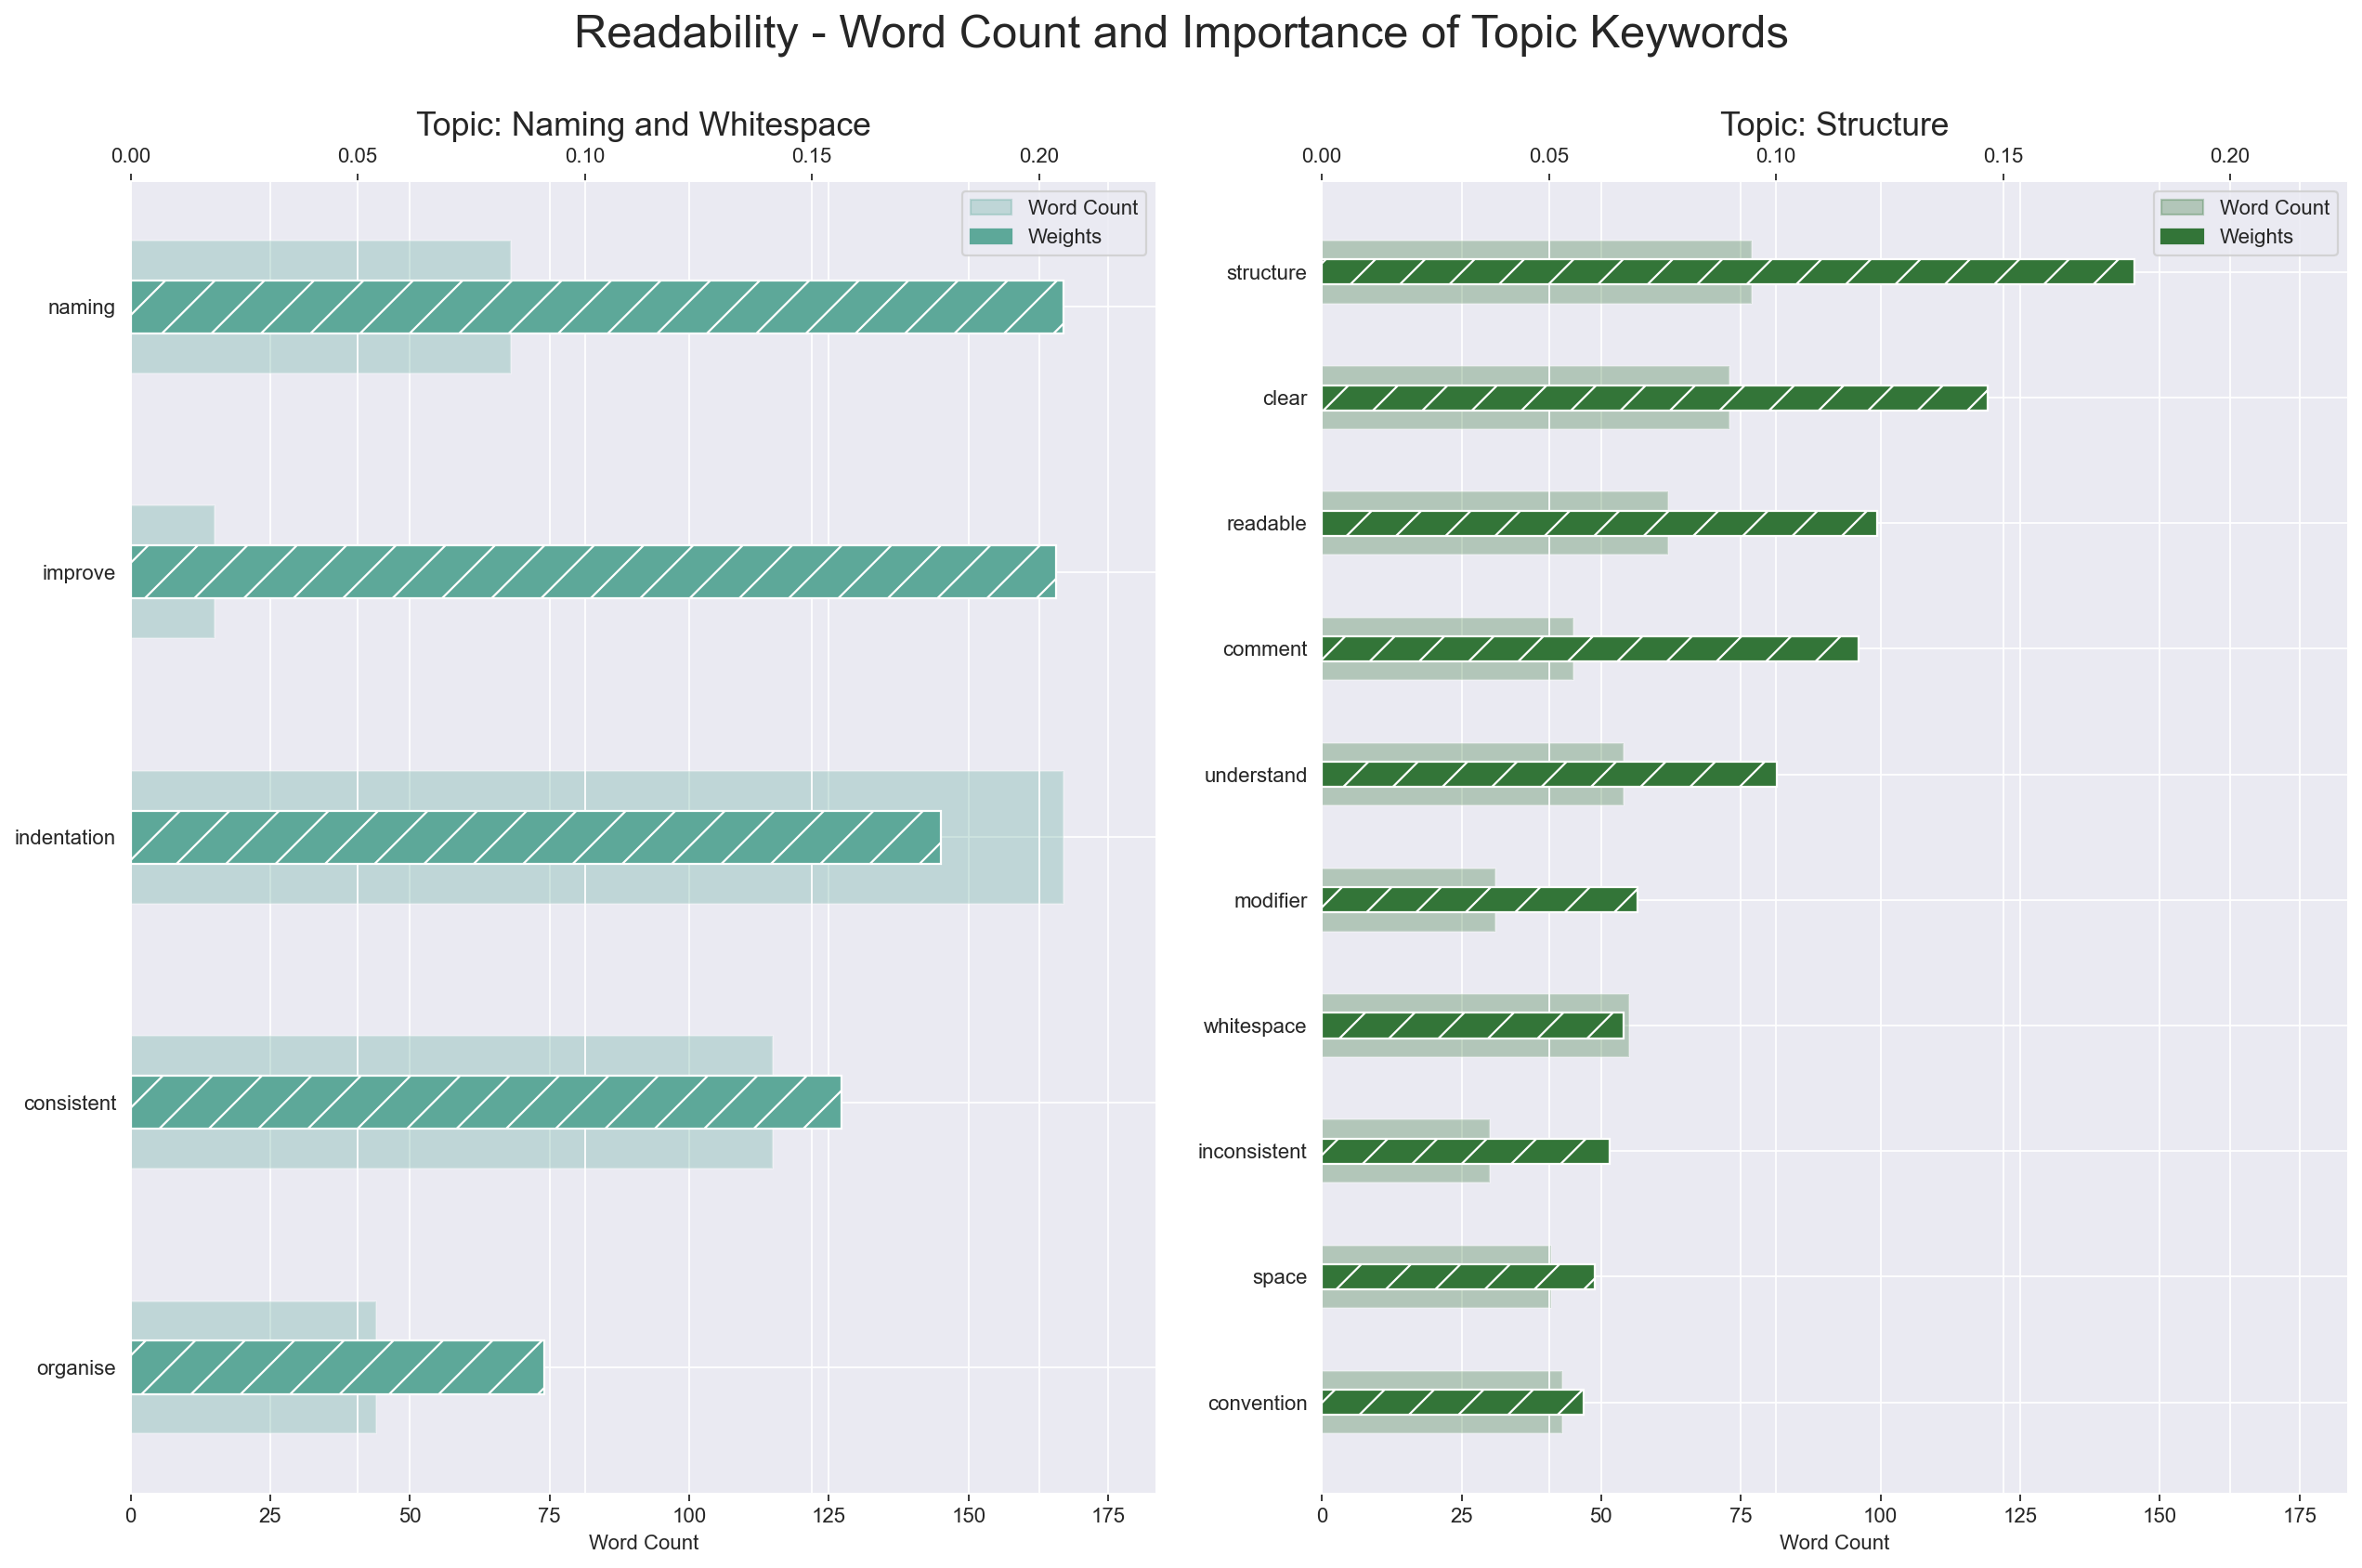

In [39]:
READABILITY_TOPIC_COUNT = 2
readability_topic_names= {1: 'Structure', 0: 'Naming and Whitespace'}
# generate_word_cloud('Readability', readability_models, READABILITY_TOPIC_COUNT, additional_stopwords=readability_additional_stopwords, topic_names=readability_topic_names)
generate_word_count('Readability', readability_models, READABILITY_TOPIC_COUNT, readability_df, topic_names=readability_topic_names, filter=True)
# run_pyLDAvis(readability_models, READABILITY_TOPIC_COUNT)

In [40]:
readability_dominant_df = generate_dominant_topics_df(readability_models[READABILITY_TOPIC_COUNT], readability_corpus, readability_df, READABILITY_TOPIC_COUNT, readability_topic_names)
readability_dominant_df.to_csv('../data/dominant_topics_readability.csv', index=False)
readability_dominant_df.head()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_95683/2469731638.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)


,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics
0,18.0,The code use meaningful identifier names and a...,15,1,"[code, use, name, way, flow]",Naming and Whitespace,0.500000,"naming, improve, indentation, consistent, orga...","[(Naming and Whitespace, 0.5), (Structure, 0.5)]"
1,620.0,Code is well organized into logical classes an...,15,1,"[code, indentation, whitespace, use, name, cle...",Structure,0.733048,"structure, clear, readable, comment, understan...","[(Structure, 0.73304796), (Naming and Whitespa..."
2,466.0,"The code is well-organized, consistently inden...",15,1,"[code, indent, use, name, whitespace, consiste...",Structure,0.652110,"structure, clear, readable, comment, understan...","[(Structure, 0.65210956), (Naming and Whitespa..."
3,591.0,The code is well organized and readable. Inden...,15,1,"[code, readable, indentation, whitespace, use,...",Structure,0.726875,"structure, clear, readable, comment, understan...","[(Structure, 0.72687477), (Naming and Whitespa..."
4,587.0,The code is well organized and readable. Inden...,15,1,"[code, readable, indentation, whitespace, use,...",Structure,0.726873,"structure, clear, readable, comment, understan...","[(Structure, 0.7268733), (Naming and Whitespac..."


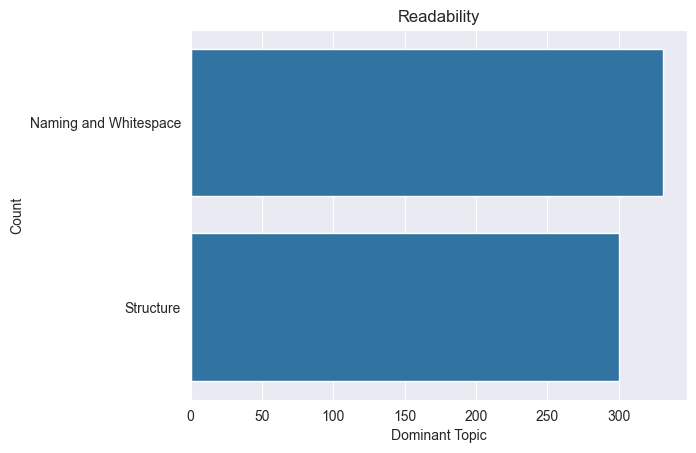

In [41]:
plot_dominant_topic('Readability', readability_dominant_df)

### Documentation

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

   topic_count  coherence
2            4 -13.843582


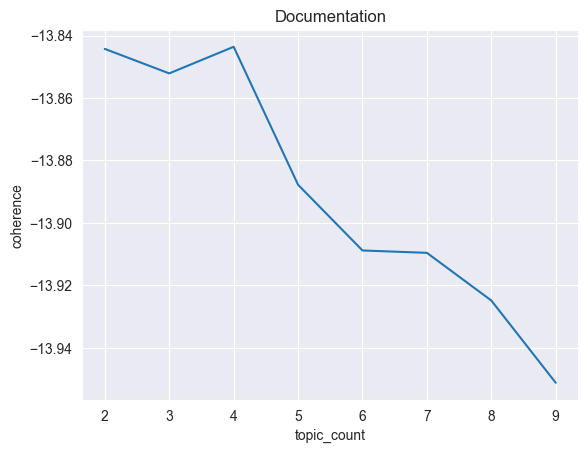

In [42]:
doc_additional_stopwords = ['appropriate', 'task', 'great', 'detailed', 'provide', 'miss', 'class', 'explain', 'use', 'base', 'achieve', 'method', 'function', 'include', 'behaviour', 'behavior', 'code', 'file', 'return', 'purpose', 'functionality', 'elaboration', 'type', 'system', 'general', 'color', 'display', 'value', 'representation', 'annotation', 'parameter', 'add', 'perfect', 'specify', 'report', 'understanding', 'consist', 'solid', 'suggest', 'structured', 'write', 'accompany', 'role','improve', 'challenge', 'view', 'simulator', 'accomplish', 'attempt', 'input', 'output', 'overall', 'description', 'understand', 'variable', 'complex', 'obvious', 'well', 'structure', 'student', 'number', 'line']
documentation_models, documentation_corpus, documentation_df = run_lda('Documentation', doc_additional_stopwords)

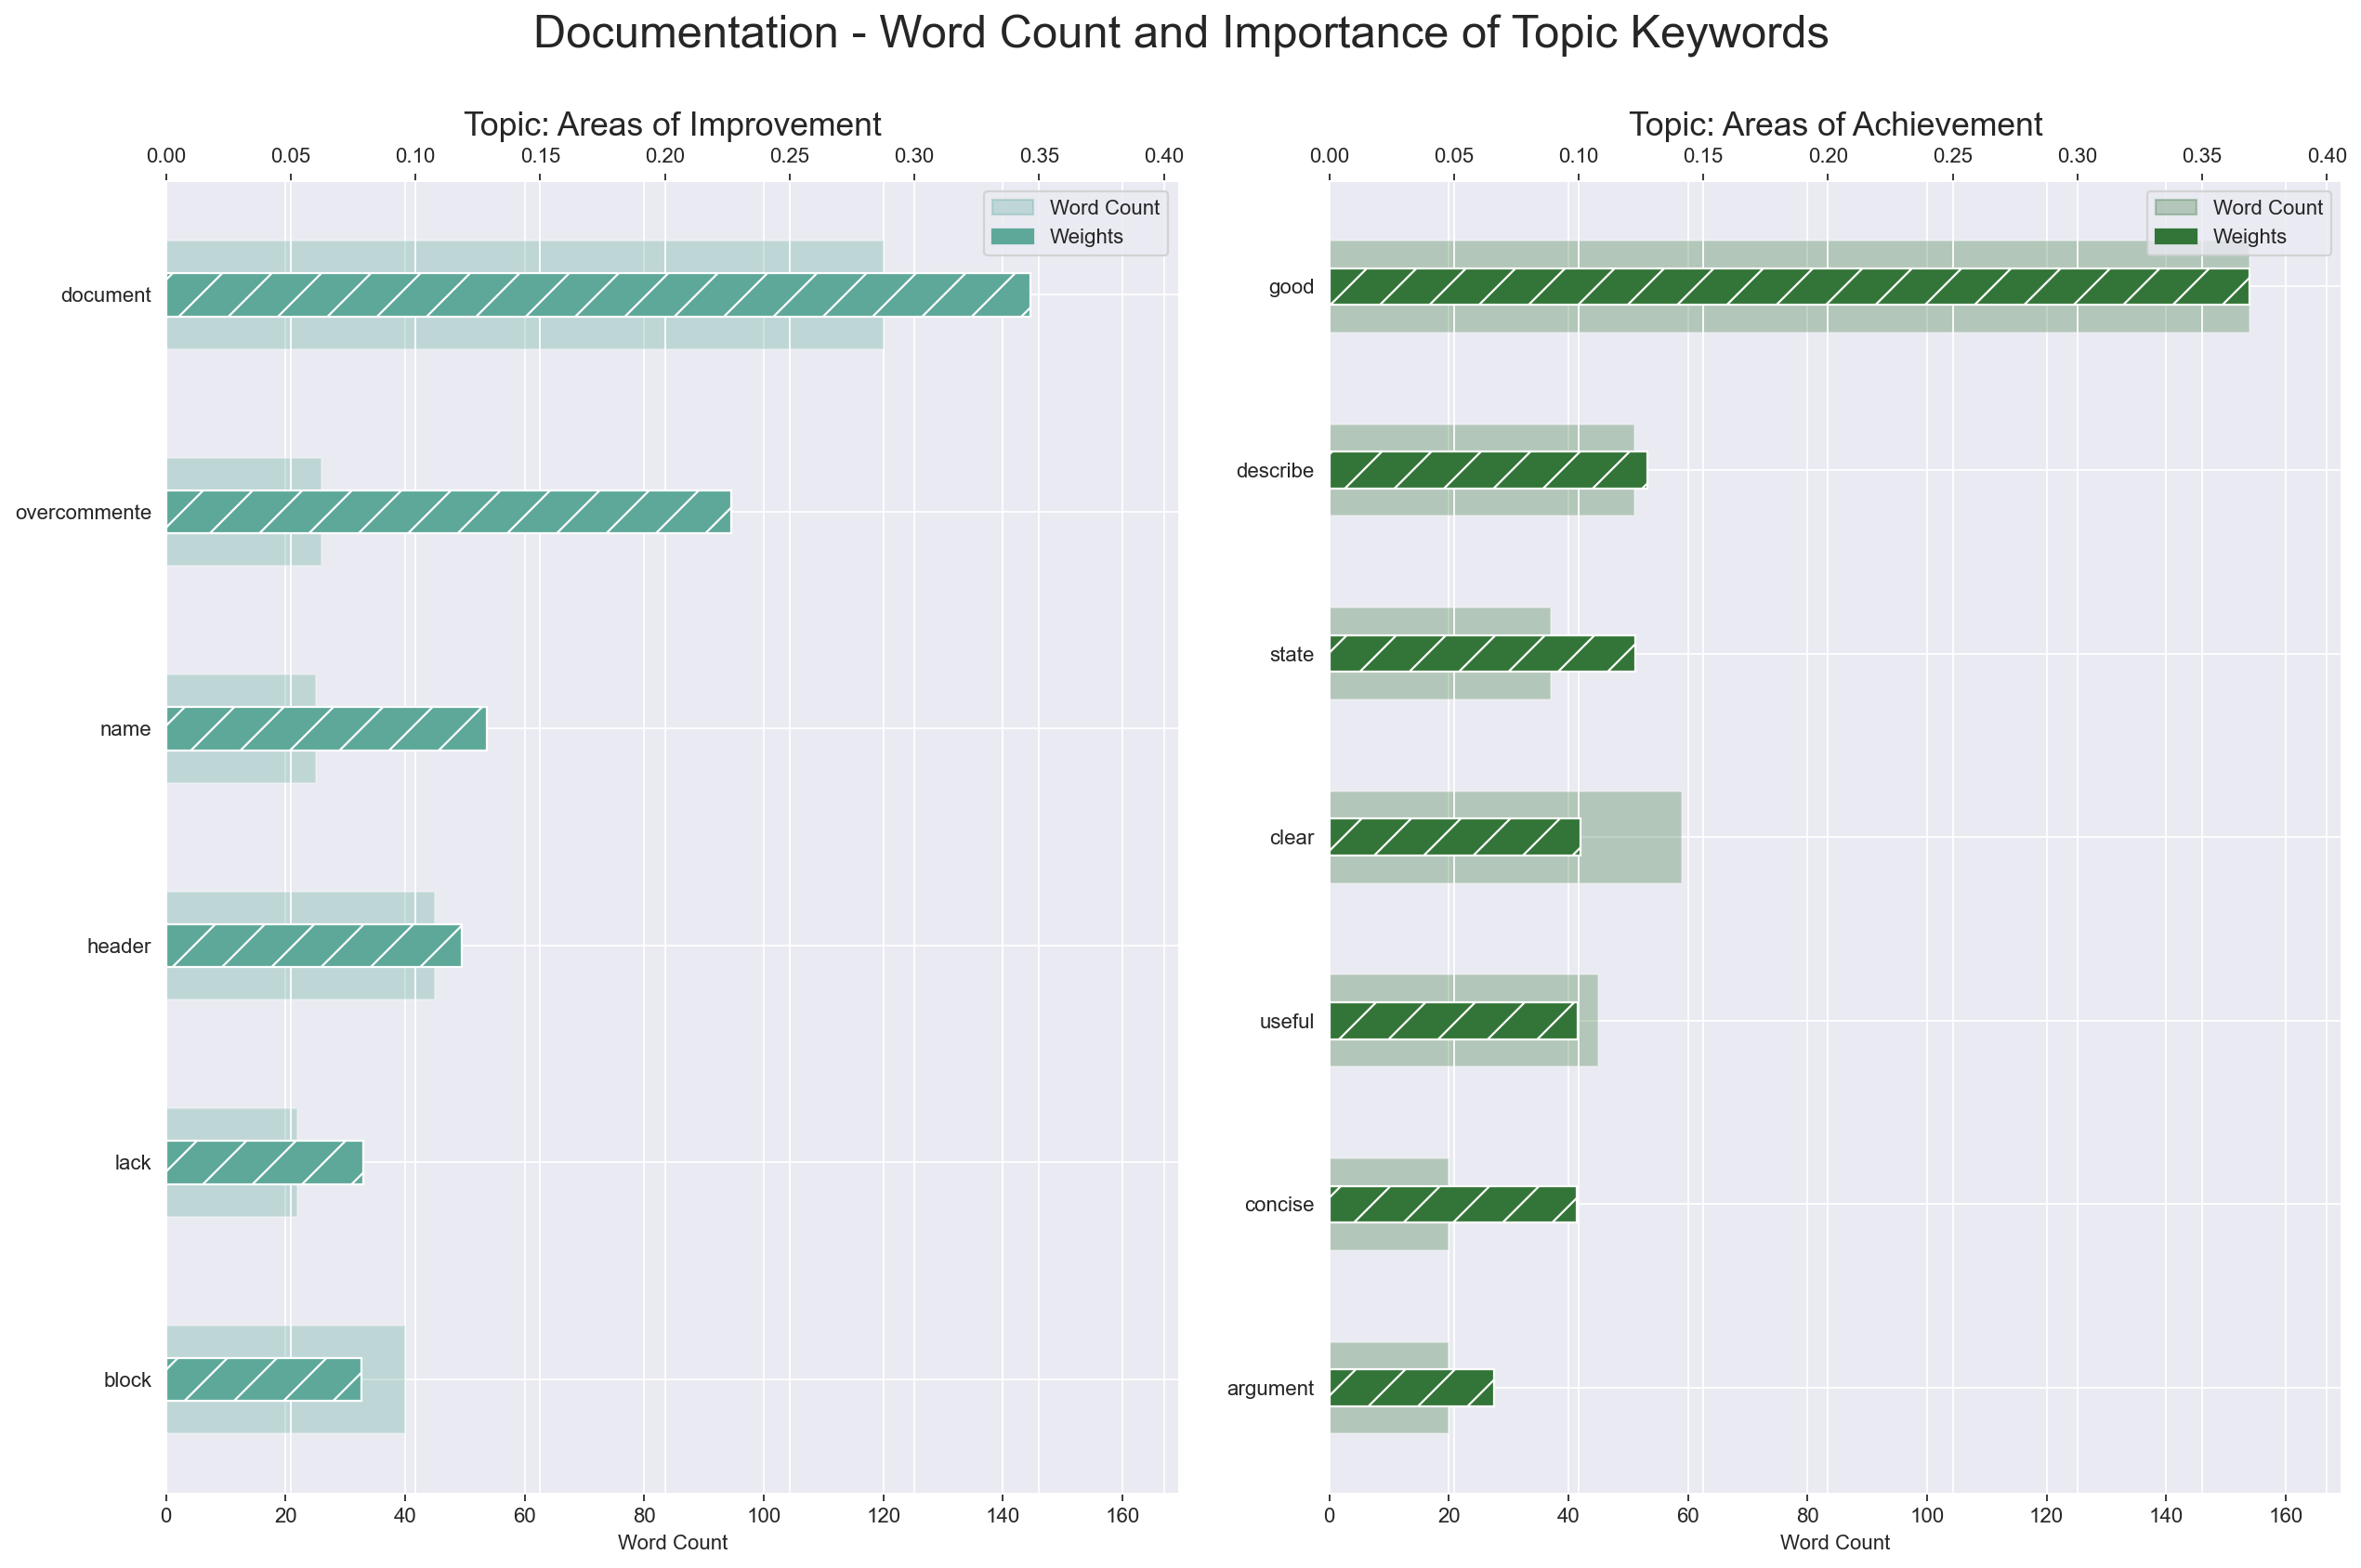

In [43]:
DOC_TOPIC_COUNT = 2
doc_topic_names = {0: 'Areas of Improvement', 1: 'Areas of Achievement'}
# generate_word_cloud('Documentation',documentation_models, DOC_TOPIC_COUNT, additional_stopwords=doc_additional_stopwords, topic_names=doc_topic_names)
generate_word_count('Documentation',documentation_models, DOC_TOPIC_COUNT, documentation_df, topic_names=doc_topic_names, filter=True )
# run_pyLDAvis(documentation_models, DOC_TOPIC_COUNT)

In [44]:
documentation_dominant_df = generate_dominant_topics_df(documentation_models[DOC_TOPIC_COUNT], documentation_corpus, documentation_df, DOC_TOPIC_COUNT, doc_topic_names)
documentation_dominant_df.to_csv('../data/dominant_topics_documentation.csv', index=False)
documentation_dominant_df.head()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_95683/2469731638.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)


,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics
0,18.0,The code is exceptionally well documented. Eac...,15,1,"[document, clear, comment, describe, comment, ...",Areas of Achievement,0.525129,"good, describe, state, clear, useful, concise,...","[(Areas of Achievement, 0.5251294), (Areas of ..."
1,620.0,The code is exceptionally well documented. Eac...,15,1,"[document, clear, comment, describe, comment, ...",Areas of Achievement,0.525130,"good, describe, state, clear, useful, concise,...","[(Areas of Achievement, 0.52512985), (Areas of..."
2,466.0,The code is very well documented. Nearly every...,15,1,"[document, block, clear, useful, comment, head...",Areas of Improvement,0.516375,"document, overcommente, name, header, lack, bl...","[(Areas of Improvement, 0.51637506), (Areas of..."
3,591.0,The code is exceptionally well documented. Eac...,15,1,"[document, clear, comment, describe, comment, ...",Areas of Achievement,0.525128,"good, describe, state, clear, useful, concise,...","[(Areas of Achievement, 0.52512795), (Areas of..."
4,587.0,The code is exceptionally well documented. Eac...,15,1,"[document, clear, comment, describe, comment, ...",Areas of Achievement,0.525130,"good, describe, state, clear, useful, concise,...","[(Areas of Achievement, 0.52512956), (Areas of..."


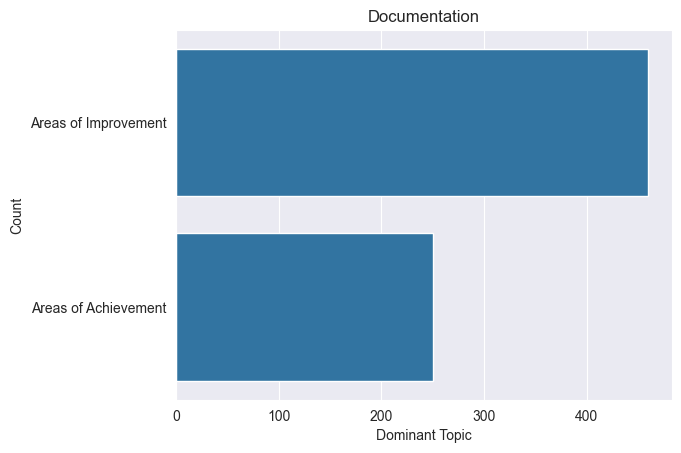

In [45]:
plot_dominant_topic('Documentation', documentation_dominant_df)